In [5]:
import seaborn as sns

dir(sns.scatterplot.__defaults__.__str__.)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__objclass__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']

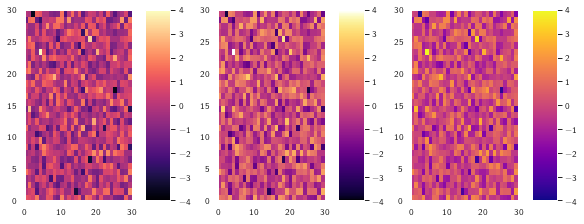

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

base_colors = ('red', 'green', 'blue')
mod_plasma = pd.read_csv('mod_plasma.csv', header=None)
mod_plasma.rename(columns={i: c for i, c in enumerate(base_colors)}, inplace=True)
mp_list = [mod_plasma.iloc[i].values for i in range(mod_plasma.shape[0])]
m_plasma = ListedColormap([mod_plasma.iloc[i].values for i in range(mod_plasma.shape[0])])
plasma = cm.get_cmap('plasma', 256)
magma = cm.get_cmap('magma', 256)

plot_examples([magma, m_plasma, plasma])

In [9]:
# ###################################
# # Average Ground Truth Replicates #
# ###################################

# import glob
# import numpy as np
# import os
# import pandas as pd
# import random

# def seed_everything(seed=42):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)

# seed_everything(42)
# seeds = [random.randint(1, 100000) for i in range(64)]
# datasets = ('compas', 'german', 'income', 'titanic')
# exhaustive_reps = {
#     d: [pd.read_csv(f'results/exhaustive/{d}_cv_exhaustive_{str(s)}.csv')
#         for s in seeds]
#     for d in datasets
# }
# avg_dfs = {d: pd.concat(exhaustive_reps[d]).groupby(['pipe']).mean().reset_index() for d in datasets}
# for d in datasets:
#     avg_dfs[d].to_csv(f'results/{d}_cv_exhaustive.csv', index=False)

# #########################################################################
# # Reference values to ground truth, original values kept in repeats_old #
# #########################################################################

# datasets = ('compas', 'german', 'income', 'titanic')

# for d in datasets:
#     ex = pd.read_csv(f'results/{d}_cv_exhaustive.csv')
#     df_paths = glob.glob(f'results/repeats/{d}*')
#     for path in df_paths:
#         df = pd.read_csv(path)
#         df = df.merge(ex, how='left', on='pipe', suffixes=['_old', ''])
#         df = df.loc[:, ~df.columns.str.endswith('_old')]
#         df.to_csv(path, index=False)

In [1]:
df = pd.read_csv(f'results/income_cv_exhaustive.csv', index_col='pipe').reset_index()
splits = df['pipe'].str.split(',', expand=True)

df['encoder'] = splits[0].str.rpartition('_')[0]
df['imputer'] = splits[1].str.rpartition('_')[0]
abbvs = {'sampler': 'samp', 'scaler': 'scale', 'select': 'sel'}
for col in abbvs:
    df[col] = [
        x.rpartition('_')[0] if abbvs[col] in x
        else y.rpartition('_')[0] if abbvs[col] in y
        else z.rpartition('_')[0]
        for x, y, z in zip(splits[2], splits[3], splits[4])
    ]
df['permutation'] = [','.join(i) for i in zip(splits[2].str.rpartition('_')[2],
                                              splits[3].str.rpartition('_')[2],
                                              splits[4].str.rpartition('_')[2])]


dp_props = (0, 50,100)
for i in dp_props:
    df[f'{str(i)}, {str(100 - i)}'] = df.dp*i + df.accu*(100 - i)

In [2]:
combs = [f'{str(i)}, {str(100 - i)}' for i in dp_props]
best_vals = {c: df.iloc[df[c].idxmin()] for c in combs}

for c in combs:
    print(f'{c}: pipe: {best_vals[c]["pipe"]}, accu: {best_vals[c].accu}, dp: {best_vals[c].dp}')

0, 100: pipe: onehot_enc,mean_imp,no_samp,no_scale,no_sel, accu: 0.15484782408402678, dp: 0.1826339265570796
50, 50: pipe: count_enc,mean_imp,no_samp,no_sel,norm_scale, accu: 0.20555265501673808, dp: 0.02627425494383064
100, 0: pipe: loo_enc,mean_imp,no_samp,no_sel,norm_scale, accu: 0.24080955744602414, dp: 0.0


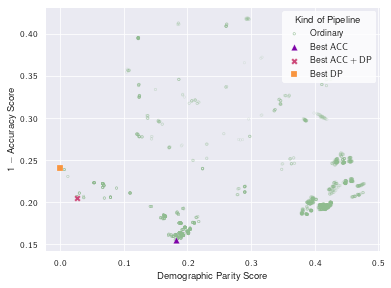

In [18]:
import matplotlib as mpl

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']}
)

mpl.rc('text.latex', preamble=r'\usepackage{sansmathfonts}\usepackage{helvet}\renewcommand{\rmdefault}{\sfdefault}')

pal = 'plasma'
sns.set(rc={'figure.figsize':(6, 4.5)})
sns.set_theme(context='paper', style='darkgrid', palette=pal)
palette = sns.color_palette(pal)

markers = ('^', 'X', 's', 'P')
# markers = ('^', 'v', '<', '>', 's', 'D', 'd', 'p', 'H', 'h', '8', 'P', 'X', '*')

fig, ax = plt.subplots()

scat_col = 'darkseagreen'
#marker = markers[0]
marker = '.'
sns.scatterplot(data=df, x='dp', y='accu', alpha=0.3, ec=scat_col, fc='none', marker=marker)
plt.scatter([], [], marker=marker, ec=scat_col, fc='none', lw=0.5, label="Regular Pipelines")

plt.xlabel('Demographic Parity Score')
plt.ylabel('1 − Accuracy Score')
# plt.xlim(-0.02, 0.71)
# plt.ylim(0.04, 0.47)

for i, c in enumerate(combs):
    plt.scatter(best_vals[c].dp,
                best_vals[c].accu, alpha=1,
                marker=markers[i], s=40, label=c,
                color=sns.color_palette(pal, 3)[i],
                edgecolors='white', linewidths=0.2)
    
handles, labels = ax.get_legend_handles_labels()
labels= ('Ordinary', r'Best $\mathrm{ACC}$', r'Best $\mathrm{ACC} + \mathrm{DP}$', r'Best $\mathrm{DP}$')

l = plt.legend(handles, labels, title='Kind of Pipeline',
               loc='best')

plt.setp(l.get_title(), multialignment='center')
l.get_frame().set_color('white')
    
for lh in l.legendHandles:
    lh.set_alpha(1)

plt.savefig(f"plots/pareto_scatter.pdf", bbox_inches='tight')
plt.show()

In [20]:
##############################
### Pareto Front Functions ###
##############################

import graphviz
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
import tol_colors as tc

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm, trange

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']}
)

mpl.rc('text.latex', preamble=r'\usepackage{sansmathfonts}\usepackage{helvet}\renewcommand{\rmdefault}{\sfdefault}')

pal = 'plasma'
sns.set(rc={'figure.figsize':(6, 4.5)})
sns.set_theme(context='paper', style='darkgrid', palette=pal)
palette = sns.color_palette(pal)
bright_pal = sns.color_palette(list(tc.tol_cset('bright')))



def pareto_front(df, cols=['dp', 'accu']):
    arr = df[cols].to_numpy()
    is_front = np.ones(arr.shape[0], dtype = bool)
    for i, row in enumerate(arr):
        if is_front[i]:
            is_front[is_front] = np.any(arr[is_front] < row, axis=1)  # Keep any point with a lower metric
            is_front[i] = True  # And keep self
    front_df = df.iloc[is_front]
    fdf = front_df.sort_values(by=[cols[0]])
    return fdf

def haus(df1, df2, var1='accu', var2='dp'):
    def dist(row1, row2):
        return ((row1[var1] - row2[var1])**2 + (row1[var2] - row2[var2])**2)**0.5
    passes = [(df1, df2), (df2, df1)]
    haus = 0
    for p in passes:
        for i in range(p[0].shape[0]):
            dists = []
            r1 = p[0].iloc[i]
            for j in range(p[1].shape[0]):
                r2 = p[1].iloc[j]
                dists.append(dist(r1, r2))
            haus = min(dists) if min(dists) > haus else haus
    return haus

def avg_haus(df1, df2, var1='accu', var2='dp'):
    def dist(row1, row2):
        return ((row1[var1] - row2[var1])**2 + (row1[var2] - row2[var2])**2)**0.5
    passes = [(df1, df2), (df2, df1)]
    avg_dists = []
    for p in passes:
        min_dists = []
        for i in range(p[0].shape[0]):
            dists = []
            r1 = p[0].iloc[i]
            for j in range(p[1].shape[0]):
                r2 = p[1].iloc[j]
                dists.append(dist(r1, r2))
            min_dist = min(dists)
            min_dists.append(min_dist)
        avg_dist = sum(min_dists) / len(min_dists)
        avg_dists.append(avg_dist)
    avg_haus = sum(avg_dists) / 2
    return avg_haus

def dir_haus(df1, df2, var1='accu', var2='dp'):
    '''Distance from farthest point in df2 that is closest to some point in df1'''
    def dist(row1, row2):
        return ((row1[var1] - row2[var1])**2 + (row1[var2] - row2[var2])**2)**0.5
    min_dists = []
    for i in range(df1.shape[0]):
        dists = []
        r1 = df1.iloc[i]
        for j in range(df2.shape[0]):
            r2 = df2.iloc[j]
            dists.append(dist(r1, r2))
        min_dist = min(dists)
        min_dists.append(min_dist)
    return max(min_dists)

def get_fronts(df, best_df, exp='policy'):
    gens = sorted(df.gen.unique())
    policy_results = {}

    for p in df[exp].unique():
        policy_results[p] = {'fronts': [], 'haus': [], 'avg_haus': [], 'dir_haus': []}
        for g in gens:
            temp_front = pareto_front(df[(df[exp] == p) & (df.gen <= g)])
            temp_dist = haus(temp_front, best_df)
            temp_avg = avg_haus(temp_front, best_df)
            temp_dir = dir_haus(temp_front, best_df)
            policy_results[p]['fronts'].append(temp_front)
            policy_results[p]['haus'].append(temp_dist)
            policy_results[p]['avg_haus'].append(temp_avg)
            policy_results[p]['dir_haus'].append(temp_dir)
    return policy_results

######################
### Plot Functions ###
######################

# markers = ('^', 'v', '<', '>', 's', 'D', 'd', 'p', 'H', 'h', '8', 'P', 'X', '*')
markers = ('^', 'X', 's', 'P', 'D', 'd')
    
def pareto_scatter(best_df, dataset, ex_df, exp_desc, exp_tag, results,
                   show, save, **kwargs):
    fig, ax = plt.subplots()
    
    sns.scatterplot(data=ex_df, x='dp', y='accu', alpha=0.2, color='lightslategray')

    for i, p in enumerate(results):
        accu_jit = np.random.normal(0, 0.0015, results[p]['fronts'][20].shape[0])
        dp_jit = np.random.normal(0, 0.0025, results[p]['fronts'][20].shape[0])
        results[p]['fronts'][20].accu = results[p]['fronts'][20].accu + accu_jit
        results[p]['fronts'][20].dp = results[p]['fronts'][20].dp + dp_jit
        
        plt.scatter(results[p]['fronts'][20].dp,
                    results[p]['fronts'][20].accu, alpha=0.6,
                    marker=markers[i], s=50, label=p,
                    color=sns.color_palette(pal, 6)[i],
                    edgecolors='white', linewidths=0.2)
    
    plt.xlabel('Demographic Parity Score')
    plt.ylabel('1 − Accuracy Score')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [l[1:-1] for l in labels]
    
    order = [i for i in range(0, len(labels))]
    l = plt.legend([handles[idx] for idx in order],
                   [labels[idx] for idx in order],
                   title=exp_desc,
#                    bbox_to_anchor=(1, 0.5),
                   loc='best',
                   frameon=True)
    l.get_frame().set_color('white')
    
    for lh in l.legendHandles:
        lh.set_alpha(1)
    
    plt.setp(l.get_title(), multialignment='center')
    
    if save:
        plt.savefig(f"plots/{exp_tag}/{dataset}/pareto_scatter.pdf", bbox_inches='tight')
    if not show:
        plt.close()
    
def pareto_scatter2(best_df, dataset, ex_df, exp_desc, exp_tag, results,
                   show, save, **kwargs):
    fig, ax = plt.subplots()
    
    sns.scatterplot(data=ex_df, x='dp', y='accu', alpha=0.6, color='lightslategray')
    
    plt.plot(best_df.dp, best_df.accu, 'o-', label='Pareto Front', color='tomato')
    
    plt.xlabel('Demographic Parity Score')
    plt.ylabel('1 − Accuracy Score')
    
    handles, labels = ax.get_legend_handles_labels()
    
    order = [i for i in range(0, len(labels))]
    l = plt.legend([handles[idx] for idx in order],
                   [labels[idx] for idx in order],
#                    bbox_to_anchor=(1, 0.5),
                   loc='best',
                   frameon=True)
    l.get_frame().set_color('white')
    
    for lh in l.legendHandles:
        lh.set_alpha(1)
    
    plt.setp(l.get_title(), multialignment='center')
    
    if save:
        plt.savefig(f"plots/{exp_tag}/{dataset}/pareto_scatter2.pdf", bbox_inches='tight')
    if not show:
        plt.close()
        
def pareto_lines(best_df, dataset, exp_desc, exp_tag, results,
                 show, save, **kwargs):
    fig, ax = plt.subplots()
    
    for i, p in enumerate(results):
        plt.plot(results[p]['fronts'][20].dp,
                 results[p]['fronts'][20].accu,
                 lw=0, alpha=0.8, marker=markers[i], ms=10, label=p, color=palette[i])
    
    plt.plot(best_df.dp, best_df.accu, label='Pareto Front', color='thistle', lw=6, alpha=0.4)

    plt.xlabel('Demographic Parity')
    plt.ylabel('1 − Accuracy')
#     plt.title(f"Pareto Fronts Estimated by {exp_desc}")

    l = plt.legend(title=exp_desc, bbox_to_anchor=(1, 0.5), loc='center left', framealpha=0)
    plt.setp(l.get_title(), multialignment='center')
    if save:
        plt.savefig(f"plots/{exp_tag}/{dataset}/pareto_lines.pdf", bbox_inches='tight')
    if not show:
        plt.close()
        
def front_distance(best_df, dataset, exp_desc, exp_tag, gens, results,
                   show, save, **kwargs):
    fig, ax = plt.subplots()

    for i, p in enumerate(results):
        plt.plot(gens, results[p]['avg_haus'], lw=3, alpha=0.6,
                 marker='.', ms=20, label=p, color = palette[i])

    plt.xlabel('Generation')
    plt.ylabel('Average Hausdorff Distance')
    plt.title('Distance from Estimated to Actual Front')
    ax.legend(title=exp_desc, bbox_to_anchor=(1, 0.5), loc='center left')
    plt.xticks([2*i for i in range(11)])
    if save:
        plt.savefig(f"plots/{exp_tag}/{dataset}/avg_haus.pdf", bbox_inches='tight')
    if not show:
        plt.close()
        
def gen_plot(plot_dict, best_df, dataset, exp_desc, exp_tag, gens, results,
             show, save, **kwargs):
    fig, ax = plt.subplots()

    for i, p in enumerate(results):
        plt.plot(gens, [getattr(results[p]['fronts'][g][plot_dict['metric']],
                                plot_dict['stat'])()
                        for g in gens],
                 lw=3, alpha=0.6,
                 marker='.', ms=20, label=p, color = palette[i])

    plt.xlabel('Generation')
    plt.ylabel(plot_dict['ylab'])
    plt.title(f"{plot_dict['stat'].capitalize()} {plot_dict['ylab']} for {exp_desc} by Generation")
    ax.legend(title=exp_desc, bbox_to_anchor=(1, 0.5), loc='center left')
    plt.xticks([2*i for i in range(11)])
    if save:
        plt.savefig(f"plots/{exp_tag}/{dataset}/{plot_dict['metric']}_{plot_dict['stat']}.pdf", bbox_inches='tight')
    if not show:
        plt.close()
        
#########################
### Plot Dictionaries ###
#########################

plot_dicts = {
    'accu_mean': {
        'metric': 'accu',
        'stat': 'mean',
        'ylab': 'Accuracy',
    },
    'accu_min': {
        'metric': 'accu',
        'stat': 'min',
        'ylab': 'Accuracy',
    },
    'dp_mean': {
        'metric': 'dp',
        'stat': 'mean',
        'ylab': 'Demographic Parity',
    },
    'dp_min': {
        'metric': 'dp',
        'stat': 'min',
        'ylab': 'Demographic Parity',
    },
    'eo_mean': {
        'metric': 'eo',
        'stat': 'mean',
        'ylab': 'Equality of Opportunity',
    },
    'eo_min': {
        'metric': 'eo',
        'stat': 'min',
        'ylab': 'Equality of Opportunity',
    },
    'eqOdds_mean': {
        'metric': 'eqOdds',
        'stat': 'mean',
        'ylab': 'Equalised Odds',
    },
    'eqOdds_min': {
        'metric': 'eqOdds',
        'stat': 'min',
        'ylab': 'Equalised Odds',
    },
}

# Saved experiments
exp_dict = {
    'dp_acc_ratio': {
        'tag': 'dp_acc_ratios',
        'exp_id': 'dp_acc_ratio',
        'exp_desc': 'DP / Accuracy Ratio',
        'n_gen': 20,
    },
    'dp_acc_reps': {
        'tag': 'dp_acc_reps',
        'exp_id': 'dp_acc_reps',
        'exp_desc': 'DP, Accuracy\nGenerations',
        'n_gen': 20,
    },
    'all_metrics': {
        'tag': 'all_metrics',
        'exp_id': 'opt_metric',
        'exp_desc': 'Pure Metrics Opt',
        'n_gen': 20,
    },
    'mut_ratios': {
        'tag': 'mut_ratios',
        'exp_id': 'mut_ratio',
        'exp_desc': 'Mutation Ratio',
        'n_gen': 20,
    },
}

def generate_plots(exp_name, dataset, exp_dict=exp_dict, plot_dicts=plot_dicts, show=False, save=True):
    # Ground truth dataset
    ex_df = pd.read_csv(f"results/{dataset}_cv_exhaustive.csv")
    # Experiment variables
    exp_tag, exp_id, exp_desc, n_gen = (exp_dict[exp_name][k]
                                        for k in exp_dict[exp_name])
    df = pd.read_csv(f"results/repeats/{dataset}_{exp_tag}_28222.csv")
    gens = range(n_gen + 1)
    # Create directory if necessary
    if not os.path.exists(f'plots/{exp_tag}'):
        os.makedirs(f'plots/{exp_tag}')
    if not os.path.exists(f'plots/{exp_tag}/{dataset}'):
        os.makedirs(f'plots/{exp_tag}/{dataset}')
    # Get estimated fronts for experiment
    best_df = pareto_front(ex_df)
    results = get_fronts(df, best_df, exp=exp_id)
    
    # pack plot arguments
    kwargs = {
        'best_df': best_df,
        'dataset': dataset,
        'exp_desc': exp_desc,
        'ex_df': ex_df,
        'exp_tag': exp_tag,
        'gens': gens,
        'results': results,
        'save': save,
        'show': show,
    }
    
    # Generate plots
#     fl = [pareto_scatter, pareto_lines, front_distance,]
    fl = [pareto_scatter2]
    for f in fl:
        f(**kwargs)
#     for plot_d in plot_dicts:
#         gen_plot(plot_dicts[plot_d], **kwargs)
        
# ##########################
# ### Generate all plots ###
# ##########################

# # datasets = ('compas', 'german', 'income', 'titanic')
# datasets = ('income')
# for exp in tqdm(exp_dict, desc='Experiment'):
#     for dset in tqdm(datasets, desc='Dataset', leave=False):
#         generate_plots(exp, dset)

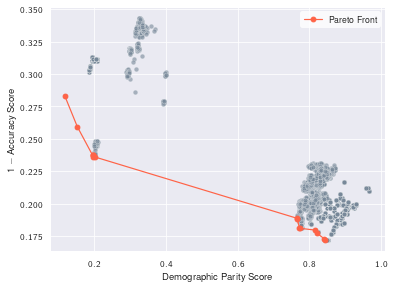

In [21]:
########################
### Show single plot ###
########################

generate_plots('dp_acc_reps', 'titanic', show=True, save=True)

In [28]:
#####################
# Replication Plots #
#####################

rep_path = 'results/repeats'
reps = os.listdir(rep_path)
dsets = ('compas', 'german', 'income', 'titanic')

experiments = {
    'acc_dp_reps': 'acc_dp_reps',
    'all_metrics': 'opt_metric',
    'dp_acc_reps': 'dp_acc_reps',
    'dp_acc_ratios': 'dp_acc_ratio',
    'lreps': 'reps',
}

# Best attainable metrics
metrics = ['dp', 'eo', 'eqOdds', 'accu']

dfs = {}
for exp in experiments:
    dfs[exp] = {}
    for dset in dsets:
        exp_list = list(filter(lambda k: (dset in k) and (exp in k), reps))
        rep_dfs = [pd.read_csv(f'{rep_path}/{file}') for file in exp_list]
        rdf = pd.concat(rep_dfs, ignore_index=True)
        dfs[exp][dset] = rdf
        
grouped_dfs = {}
for exp in experiments:
    grouped_dfs[exp] = {}
    for dset in dsets:
        grouped_dfs[exp][dset] = (
            dfs[exp][dset]
            .groupby(['gen', 'seed', experiments[exp]])
            .min()
            .reset_index()
            .sort_values(by=[experiments[exp]],
                         ascending=False)
        )

dp_dfs = {}
for exp in experiments:
    dp_dfs[exp] = {}
    for dset in dsets:
        dp_dfs[exp][dset] = (
            dfs[exp][dset].loc[dfs[exp][dset]
                               .groupby(['gen',
                                         'seed',
                                         experiments[exp]])
                               ['dp'].idxmin()]
            .sort_values(by=[experiments[exp]],
                         ascending=False)
        )

accu_dfs = {}
for exp in experiments:
    accu_dfs[exp] = {}
    for dset in dsets:
        accu_dfs[exp][dset] = (
            dfs[exp][dset].loc[dfs[exp][dset]
                               .groupby(['gen',
                                         'seed',
                                         experiments[exp]])
                               ['accu'].idxmin()]
            .sort_values(by=[experiments[exp]],
                         ascending=False)
        )

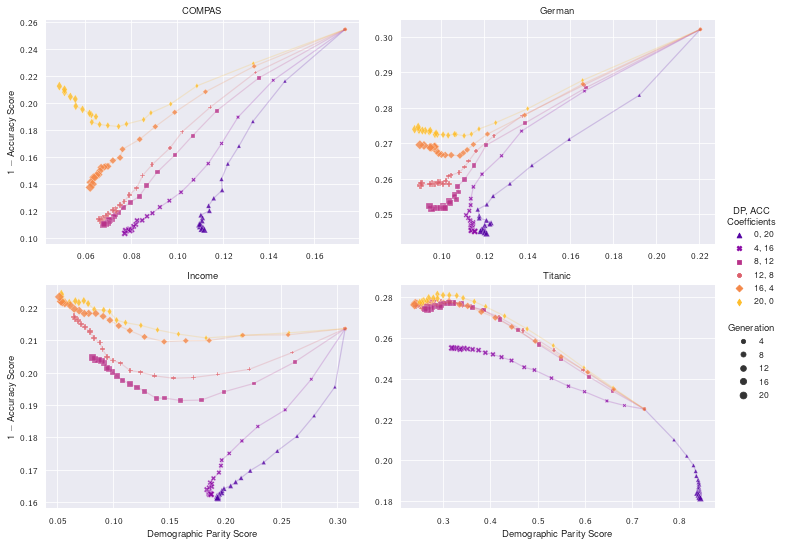

In [35]:
dset_names = ('COMPAS', 'German', 'Income', 'Titanic')
exp = 'dp_acc_ratios'
exp_vals = experiments[exp]
hue_order = ('(0, 10)', '(1, 9)', '(2, 8)', '(3, 7)', '(4, 6)',
             '(5, 5)', '(6, 4)', '(7, 3)', '(8, 2)', '(9, 1)', '(10, 0)')
selected = ('(0, 10)', '(2, 8)', '(4, 6)', '(6, 4)', '(8, 2)', '(10, 0)')
selected2 = ('(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)')
alpha_scat=0.8
alpha_rug=0.8

mdfs = {dset: dfs[exp][dset].groupby(['gen', exp_vals]).mean().reset_index() for dset in dsets}
for dset in dsets:
    mdfs[dset] = mdfs[dset][mdfs[dset][exp_vals].isin(selected)]
    mdfs[dset][exp_vals] = pd.Categorical(mdfs[dset][exp_vals], categories=selected, ordered=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
# locs = ['left', 'right'] * 2
for i, dset in enumerate(dsets):
    means_df = mdfs[dset]
    sns.lineplot(data=means_df, x='dp', y='accu', hue=exp_vals, alpha=0.2, ax=axes.flat[i], palette=pal, sort=False)
    g = sns.scatterplot(data=means_df, x='dp', y='accu', hue=exp_vals,
                        markers=markers[0:len(selected)],
                        style=exp_vals, size='gen',
                        alpha=alpha_scat, palette=pal, ax=axes.flat[i])
#     sns.rugplot(data=means_df, x='dp', y='accu', hue=exp_vals,
#                 palette=pal, alpha=alpha_rug,
#                 expand_margins=False, ax=axes.flat[i])
    axes.flat[i].set_title(f'{dset_names[i]}', loc='center')
    g.legend_.remove()

xlabs = [''] * 2 + ['Demographic Parity Score'] * 2
ylabs = ['1 − Accuracy Score', ''] * 2
# xlims = [0.038, 0.077, 0.031, 0.19]

for i, ax in enumerate(axes.flat):
    ax.set(xlabel=xlabs[i], ylabel=ylabs[i])
#     ax.set_xlim(left=xlims[i])

plt.subplots_adjust(hspace=0.18, wspace=0.13)

handles, labels = axes.flat[1].get_legend_handles_labels()
coef_handles = handles[7:13]
# coef_labels = ('(0, 20)', '(2, 18)', '(4, 16)', '(6, 14)', '(8, 12)',
#                '(10, 10)', '(12, 8)', '(14, 6)', '(16, 4)', '(18, 2)', '(20, 0)')
coef_labels = selected2
coef_labels = [l[1:-1] for l in coef_labels]
gen_handles = handles[-5:]
gen_labels = [4, 8, 12, 16, 20]

align='center'
l = fig.legend(coef_handles, coef_labels,
               title='DP, ACC\nCoefficients',
               loc=f'lower {align}',
               bbox_to_anchor=(0.943, 0.425),
               frameon=False)
l._legend_box.align = align
plt.setp(l.get_title(), multialignment='center')

gl = fig.legend(gen_handles, gen_labels,
                title='Generation',
                loc=f'upper {align}',
                bbox_to_anchor=(0.943, 0.425),
                frameon=False)
gl._legend_box.align = align

plt.savefig(f'plots/regions_{exp}.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# dset_names = ('COMPAS', 'German', 'Income', 'Titanic')
# exp = 'dp_acc_ratios'
# exp_vals = experiments[exp]
# hue_order = ('(0, 10)', '(1, 9)', '(2, 8)', '(3, 7)', '(4, 6)',
#              '(5, 5)', '(6, 4)', '(7, 3)', '(8, 2)', '(9, 1)', '(10, 0)')
# title = '(DP, Accuracy)\nCoefficients'
# alpha_scat=0.8
# alpha_rug=0.8

# min_groups = {'both': grouped_dfs, 'accu': accu_dfs, 'dp': dp_dfs}
# for group in min_groups:
#     dfs = min_groups[group]

#     mdfs = {dset: dfs[exp][dset].groupby(['gen', exp_vals]).mean().reset_index() for dset in dsets}
#     for dset in dsets:
#         mdfs[dset][exp_vals] = pd.Categorical(mdfs[dset][exp_vals], categories=hue_order, ordered=True)

#     fig, axes = plt.subplots(2, 2, figsize=(12, 10))
#     for i, dset in enumerate(dsets):
#         means_df = mdfs[dset]
#         means_df['gen'] = means_df['gen'].apply(str)
#         sns.lineplot(data=means_df, x='dp', y='accu', hue=exp_vals, alpha=0.2, ax=axes.flat[i], palette=pal, sort=False)
#         g = sns.scatterplot(data=means_df, x='dp', y='accu', hue=exp_vals,
#                             markers=markers[0:len(hue_order)],
#                             style=exp_vals, size='gen',
#                             alpha=alpha_scat, palette=pal, ax=axes.flat[i])
#         sns.rugplot(data=means_df, x='dp', y='accu', hue=exp_vals,
#                     palette=pal, alpha=alpha_rug,
#                     expand_margins=False, ax=axes.flat[i])
#         axes.flat[i].set_title(f'{dset_names[i]}', loc='center', size=12)
#         g.legend_.remove()

#     xlabs = ['']*2 + ['Demographic Parity']*2
#     ylabs = ['1 − Accuracy', ''] * 2
#     xlims = {
#         'both': [0.0225, 0.052, 0.005, 0.135],
#         'accu': [0.06, 0.096, 0.08, 0.32],
#         'dp': [0.022, 0.052, 0.006, 0.13],
#     }

#     for i, ax in enumerate(axes.flat):
#         ax.set(xlabel=xlabs[i], ylabel=ylabs[i])
#         ax.set_xlim(left=xlims[group][i])

#     plt.subplots_adjust(hspace=0.2, wspace=0.15)

#     handles, labels = g.get_legend_handles_labels()
#     rep_handles = handles[12:23]
#     rep_labels = labels[12:23]#[l[1:-1] for l in labels[12:23]]
#     gen_handles = handles[-5:]
#     gen_labels = labels[-5:]

#     rep_leg = fig.legend(rep_handles, rep_labels, title = title,
#                          loc='lower left', bbox_to_anchor=(0.9, 0.43),
#                          frameon=False)
#     gen_leg = fig.legend(gen_handles, gen_labels,
#                          title = 'Generation',
#                          loc='upper left', bbox_to_anchor=(0.9, 0.43),
#                          frameon=False)
#     plt.setp(rep_leg.get_title(), multialignment='center')

#     plt.savefig(f'plots/regions_{exp}_best_{group}.pdf', bbox_inches='tight')
#     plt.show()

In [13]:
#####################
# Replication Plots #
#####################

rep_path = 'results/repeats'
reps = os.listdir(rep_path)
dset = 'income'
dsets = ['compas', 'german', 'income', 'titanic']
dset_names = ['COMPAS', 'German', 'Income', 'Titanic']

experiments = {
    'all_metrics': 'opt_metric',
}

meta = {}
for dset in dsets:
    ex_df = pd.read_csv(f"results/{dset}_cv_exhaustive.csv")
    metrics = ['dp', 'eo', 'eqOdds', 'accu']
    best = {m: ex_df[m].min() for m in metrics}
    best_sub = {m: ex_df[m].min() for m in ['dp', 'accu']}

    dfs = {}
    for exp in experiments:
        exp_list = list(filter(lambda k: (dset in k) and (exp in k), reps))
        rep_dfs = [pd.read_csv(f"{rep_path}/{file}") for file in exp_list]
        dfs[exp] = pd.concat(rep_dfs, ignore_index=True)
    meta[dset] = dfs

for i, dset in enumerate(dsets):
    meta[dset]['all_metrics']['dset'] = dset_names[i]
to_concat = [meta[dset]['all_metrics'] for dset in dsets]
all_df = pd.concat(to_concat, ignore_index=True)

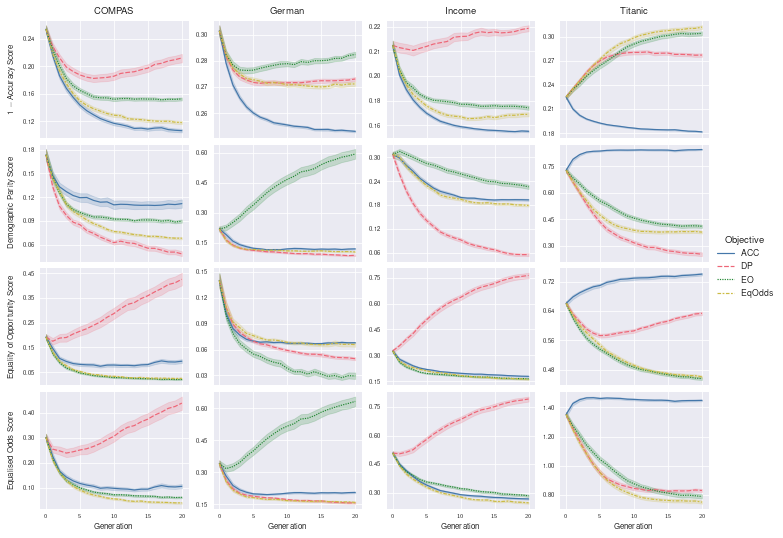

In [14]:
##########################
# Mean Metrics Evolution #
##########################

exp = 'all_metrics'
hue_order = ['(0, 0, 0, 1)', '(1, 0, 0, 0)', '(0, 1, 0, 0)', '(0, 0, 1, 0)']
metrics = ['accu', 'dp', 'eo', 'eqOdds']

fig, axes = plt.subplots(4, 4, figsize=(12, 9), sharex=True, sharey=False)

for i, metric in enumerate(metrics):
    for j, dset in enumerate(dsets):
        leg_bool = (i==3 and j==3)
        ax = axes[i, j]
        g = sns.lineplot(ax=ax, data=all_df[all_df.dset == dset_names[j]], 
                         x='gen', y=metric,
                         hue='opt_metric', hue_order=hue_order,
                         style='opt_metric', style_order=hue_order,
                         legend=leg_bool, palette=bright_pal[:4])
        if leg_bool:
            g.legend_.remove()
            
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
        ax.yaxis.labelpad = 8
        ax.tick_params(axis='both', which='major', labelsize=6, pad=0, width=0)
            
axes[2, 0].set_yticks([0.05, 0.15, 0.25, 0.35, 0.45])

xlabs = ['']*12 + ['Generation']*4
ylabs = (['1 − Accuracy Score'] + ['']*3
         + ['Demographic Parity Score'] + ['']*3
         + ['Equality of Opportunity Score'] + ['']*3
         + ['Equalised Odds Score'] + ['']*3)
titles = dset_names + ['']*12
for ax, xl, yl, t in zip(axes.flat, xlabs, ylabs, titles):
    ax.set_xlabel(xl, fontsize=8)
    ax.set_ylabel(yl, fontsize=8)
    ax.set_title(t)
plt.subplots_adjust(hspace=0.05, wspace=0.16)

handles, labels = axes.flat[-1].get_legend_handles_labels()
labels = ['ACC',
          'DP',
          'EO',
          'EqOdds']
# labels = ['Accuracy',
#           'Demographic\nParity',
#           'Equality of\nOpportunity',
#           'Equalised\nOdds']

fig.legend(handles, labels, title='Objective',
           loc='center left', bbox_to_anchor=(0.9, 0.5),
           frameon=False)

plt.savefig(f"plots/all_dsets_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

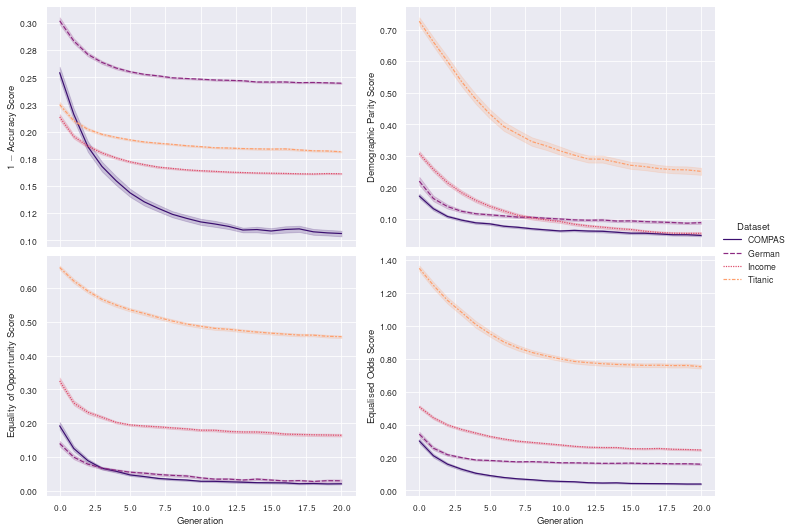

In [5]:
##########################
# Mean Metrics Evolution #
##########################

exp = 'all_metrics'
hue_order = ['(0, 0, 0, 1)', '(1, 0, 0, 0)', '(0, 1, 0, 0)', '(0, 0, 1, 0)']
metrics = ['accu', 'dp', 'eo', 'eqOdds']

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex='col', sharey=False)

for i, metric in enumerate(metrics):
    leg_bool = (i==3)
    g = sns.lineplot(ax=axes.flat[i], x='gen', y=metric,
                     data=all_df[all_df.opt_metric == hue_order[i]],
                     hue='dset', style='dset', #lw=1.5,
                     legend=leg_bool, palette=pal)
    if leg_bool:
        g.legend_.remove()
    axes.flat[i].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
xlabs = ['Generation']*4
ylabs = ['1 − Accuracy Score',
         'Demographic Parity Score',
         'Equality of Opportunity Score',
         'Equalised Odds Score']
for ax, xl, yl in zip(axes.flat, xlabs, ylabs):
    ax.set(xlabel=xl, ylabel=yl)
plt.subplots_adjust(hspace=0.03, wspace=0.16)

handles, labels = axes.flat[3].get_legend_handles_labels()

fig.legend(handles, labels, title='Dataset',
           loc='center left', bbox_to_anchor=(0.9, 0.5),
           frameon=False)

plt.savefig(f"plots/all_dsets_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

In [41]:
# #####################
# # Replication Plots #
# #####################

rep_path = 'results/repeats'
reps = os.listdir(rep_path)
dset = 'income'
dsets = ('compas', 'german', 'income', 'titanic')

experiments = {
    'acc_dp_reps': 'acc_dp_reps',
    'all_metrics': 'opt_metric',
    'dp_acc_reps': 'dp_acc_reps',
    'dp_acc_ratios': 'dp_acc_ratio',
    'lreps': 'reps',
}

# Best attainable metrics
ex_df = pd.read_csv(f"results/{dset}_cv_exhaustive.csv")
metrics = ['dp', 'eo', 'eqOdds', 'accu']
best = {m: ex_df[m].min() for m in metrics}
best_sub = {m: ex_df[m].min() for m in ['dp', 'accu']}

dfs = {}
for exp in experiments:
    exp_list = list(filter(lambda k: (dset in k) and (exp in k), reps))
    rep_dfs = [pd.read_csv(f"{rep_path}/{file}") for file in exp_list]
    rdf = pd.concat(rep_dfs, ignore_index=True)
    dfs[exp] = rdf

grouped_dfs = {}
for exp in experiments:
    grouped_dfs[exp] = (dfs[exp]
                        .groupby(['gen',
                                  'seed',
                                  experiments[exp]])
                        .min()
                        .reset_index()
                        .sort_values(by=[experiments[exp]],
                                     ascending=False))

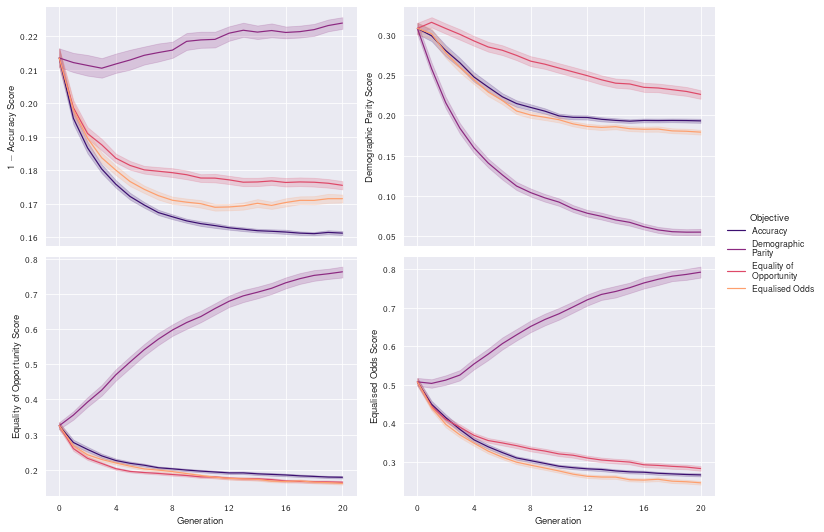

In [20]:
##########################
# Mean Metrics Evolution #
##########################

exp = 'all_metrics'
rdf = dfs[exp]
hue_order = ['(0, 0, 0, 1)', '(1, 0, 0, 0)', '(0, 1, 0, 0)', '(0, 0, 1, 0)']

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True)

sns.lineplot(ax=axes.flat[0], x='gen', y='accu', data=rdf, hue=experiments[exp], hue_order=hue_order, legend=False, palette=pal)
sns.lineplot(ax=axes.flat[1], x='gen', y='dp', data=rdf, hue=experiments[exp], hue_order=hue_order, legend=False, palette=pal)
sns.lineplot(ax=axes.flat[2], x='gen', y='eo', data=rdf, hue=experiments[exp], hue_order=hue_order, legend=False, palette=pal)
g = sns.lineplot(ax=axes.flat[3], x='gen', y='eqOdds', data=rdf, hue=experiments[exp], hue_order=hue_order, palette=pal)
g.legend_.remove()

xlabs = ['']*2 + ['Generation']*2
ylabs = ['1 − Accuracy Score', 'Demographic Parity Score',
         'Equality of Opportunity Score', 'Equalised Odds Score']

for ax, xl, yl in zip(axes.flat, xlabs, ylabs):
    ax.set(xlabel=xl, ylabel=yl)
    ax.set_xticks([4*i for i in range(6)])

plt.subplots_adjust(hspace=0.04, wspace=0.15)

# th = [plt.plot([],marker='', ls='')[0]]
# tl = [r'\textbf{Objective Metric:}']

handles, labels = axes.flat[3].get_legend_handles_labels()
# handles = th + handles
labels = ['Accuracy', 'Demographic\nParity',
          'Equality of\nOpportunity', 'Equalised Odds']
# labels = tl + labels

l = fig.legend(handles,
               labels,
               title='Objective',
               loc='center left', bbox_to_anchor=(0.905, 0.5), frameon=False)

plt.savefig(f"plots/{dset}_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

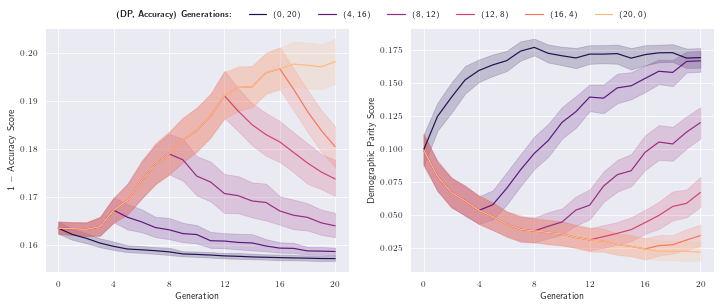

In [7]:
# ###########################
# # Best DP/Acc Repetitions #
# ###########################

# exp = 'dp_acc_reps'
# rdf = grouped_dfs[exp]

# ordered_labels = ['(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)']

# fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

# sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf,
#              hue=experiments[exp], hue_order=ordered_labels,
#              legend=False, palette=pal)
# g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf,
#                  hue=experiments[exp], hue_order=ordered_labels,
#                  palette=pal)
# g.legend_.remove()

# ylabs = ['1 − Accuracy Score', 'Demographic Parity Score']

# for ax, yl in zip(axes.flat, ylabs):
#     ax.set(xlabel='Generation', ylabel=yl)
#     ax.set_xticks([4*i for i in range(6)])
    
# th = [plt.plot([],marker='', ls='')[0]]
# tl = [r'\textbf{(DP, Accuracy) Generations:}']

# handles, labels = axes[1].get_legend_handles_labels()
# handles = th + handles
# labels = tl + labels

# l = fig.legend(handles,
#                labels,
#                ncol=7,
#                loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

# plt.savefig(f"plots/{dset}_{exp}_best.pdf", bbox_inches='tight')
# plt.show()

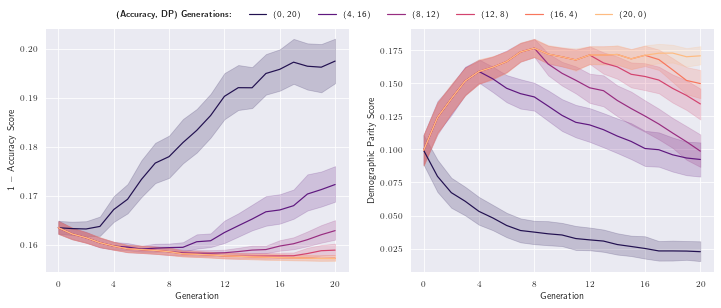

In [8]:
# ###########################
# # Best Acc/DP Repetitions #
# ###########################

# exp = 'acc_dp_reps'
# rdf = grouped_dfs[exp]

# ordered_labels = ['(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)']

# fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

# sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf,
#              hue=experiments[exp], hue_order=ordered_labels,
#              legend=False, palette=pal)
# g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf,
#                  hue=experiments[exp], hue_order=ordered_labels,
#                  palette=pal)
# g.legend_.remove()

# ylabs = ['1 − Accuracy Score', 'Demographic Parity Score']

# for ax, yl in zip(axes.flat, ylabs):
#     ax.set(xlabel='Generation', ylabel=yl)
#     ax.set_xticks([4*i for i in range(6)])

# th = [plt.plot([],marker='', ls='')[0]]
# tl = [r'\textbf{(Accuracy, DP) Generations:}']

# handles, labels = axes[1].get_legend_handles_labels()
# handles = th + handles
# labels = tl + labels

# l = fig.legend(handles,
#                labels,
#                ncol=7,
#                loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

# plt.savefig(f"plots/{dset}_{exp}_best.pdf", bbox_inches='tight')
# plt.show()

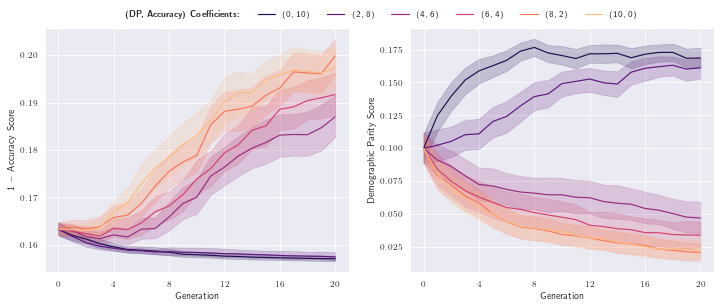

In [9]:
# ######################
# # Best DP/Acc Ratios #
# ######################

# # ordered_labels = ('(0, 10)', '(1, 9)', '(2, 8)', '(3, 7)', '(4, 6)',
# #                   '(5, 5)', '(6, 4)', '(7, 3)', '(8, 2)', '(9, 1)', '(10, 0)')
# ordered_labels = ('(0, 10)', '(2, 8)', '(4, 6)', '(6, 4)', '(8, 2)', '(10, 0)')

# exp = 'dp_acc_ratios'
# rdf = grouped_dfs[exp]
# rdf = rdf[rdf[experiments[exp]].isin(ordered_labels)]

# fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

# sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf,
#              hue=experiments[exp], hue_order=ordered_labels,
#              legend=False, palette=pal)
# g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf,
#                  hue=experiments[exp], hue_order=ordered_labels,
#                  palette=pal)
# g.legend_.remove()

# ylabs = ['1 − Accuracy Score', 'Demographic Parity Score']

# for ax, yl in zip(axes.flat, ylabs):
#     ax.set(xlabel='Generation', ylabel=yl)
#     ax.set_xticks([4*i for i in range(6)])

# th = [plt.plot([],marker='', ls='')[0]]
# tl = [r'\textbf{(DP, Accuracy) Coefficients:}']

# handles, labels = axes[1].get_legend_handles_labels()
# handles = th + handles
# labels = tl + labels

# l = fig.legend(handles,
#                labels,
#                ncol=7,
#                loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

# plt.savefig(f"plots/{dset}_{exp}_best.pdf", bbox_inches='tight')
# plt.show()

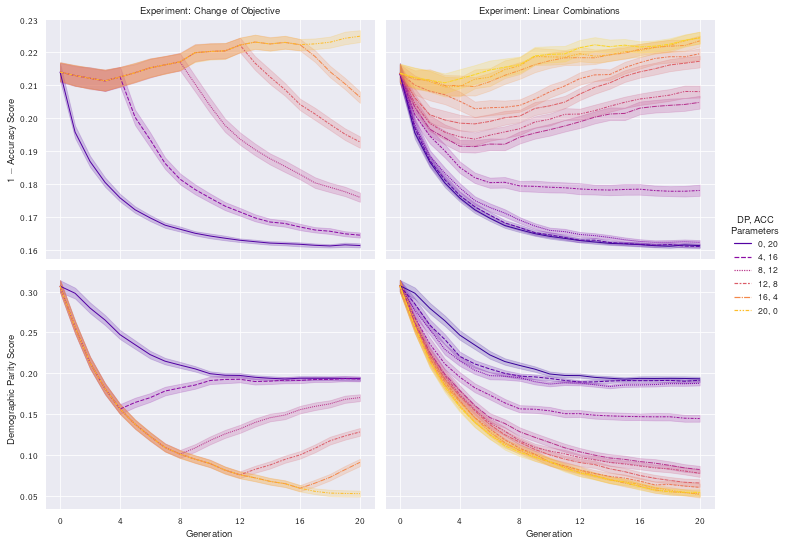

In [42]:
exp = 'dp_acc_reps'
exp2 = 'dp_acc_ratios'

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex='col', sharey='row')

g = sns.lineplot(ax=axes.flat[0], x='gen', y='accu', data=dfs[exp], hue=experiments[exp], style=experiments[exp], palette=pal, lw=1)
sns.lineplot(ax=axes.flat[1], x='gen', y='accu', data=dfs[exp2], hue=experiments[exp2], style=experiments[exp2], palette=pal, lw=1, legend=False)
sns.lineplot(ax=axes.flat[2], x='gen', y='dp', data=dfs[exp], hue=experiments[exp], style=experiments[exp], palette=pal, lw=1, legend=False)
sns.lineplot(ax=axes.flat[3], x='gen', y='dp', data=dfs[exp2], hue=experiments[exp2], style=experiments[exp2], palette=pal, lw=1,  legend=False)
g.legend_.remove()

ylabs = ['1 − Accuracy Score', '', 'Demographic Parity Score', '']
titles = ['Experiment: Change of Objective',
          'Experiment: Linear Combinations',
          '', '']
for ax, yl, t in zip(axes.flat, ylabs, titles):
    ax.set(xlabel='Generation', ylabel=yl)
    ax.set_xticks([4*i for i in range(6)])
    ax.set_title(t, loc='center')
plt.subplots_adjust(hspace=0.04, wspace=0.03)

handles, labels = axes.flat[0].get_legend_handles_labels()
labels = [l[1:-1] for l in labels]

l = fig.legend(handles,
               labels,
               title='DP, ACC\nParameters',
               loc='center right', bbox_to_anchor=(0.985, 0.5), frameon=False)
plt.setp(l.get_title(), multialignment='center')

plt.savefig(f"plots/{dset}_both_mean.pdf", bbox_inches='tight')
plt.show()

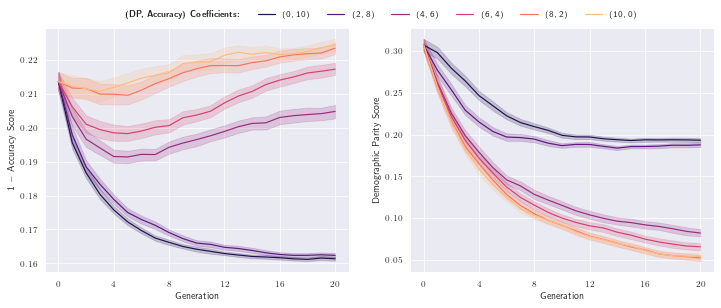

In [11]:
exp = 'dp_acc_ratios'
rdf = dfs[exp]

# Hack for comparison purposes
sub_obj = list(rdf[experiments[exp]].unique())[::2]
rdf = rdf[rdf[experiments[exp]].isin(sub_obj)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf, hue=experiments[exp], legend=False, palette=pal)
g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf, hue=experiments[exp], palette=pal)
g.legend_.remove()
    
ylabs = ['1 − Accuracy Score', 'Demographic Parity Score',]

for ax, yl in zip(axes.flat, ylabs):
    ax.set(xlabel='Generation', ylabel=yl)
    ax.set_xticks([4*i for i in range(6)])

th = [plt.plot([],marker='', ls='')[0]]
tl = [r'\textbf{(DP, Accuracy) Coefficients:}']

handles, labels = axes[1].get_legend_handles_labels()
handles = th + handles
labels = tl + labels

l = fig.legend(handles,
               labels,
               ncol=7,
               loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

plt.savefig(f"plots/{dset}_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

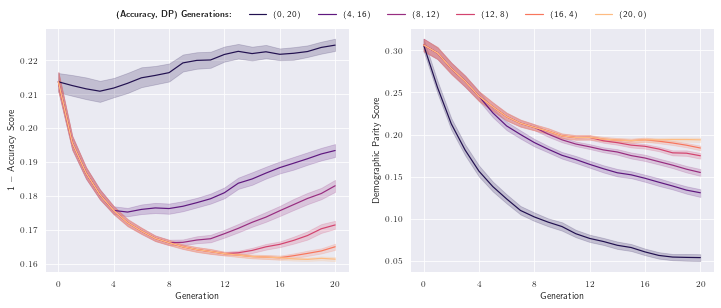

In [12]:
exp = 'acc_dp_reps'
rdf = dfs[exp]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf, hue=experiments[exp], legend=False, palette=pal)
g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf, hue=experiments[exp], palette=pal)
g.legend_.remove()

ylabs = ['1 − Accuracy Score', 'Demographic Parity Score',]

for ax, yl in zip(axes.flat, ylabs):
    ax.set(xlabel='Generation', ylabel=yl)
    ax.set_xticks([4*i for i in range(6)])

th = [plt.plot([],marker='', ls='')[0]]
tl = [r'\textbf{(Accuracy, DP) Generations:}']

handles, labels = axes[1].get_legend_handles_labels()
handles = th + handles
labels = tl + labels

l = fig.legend(handles,
               labels,
               ncol=7,
               loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

plt.savefig(f"plots/{dset}_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

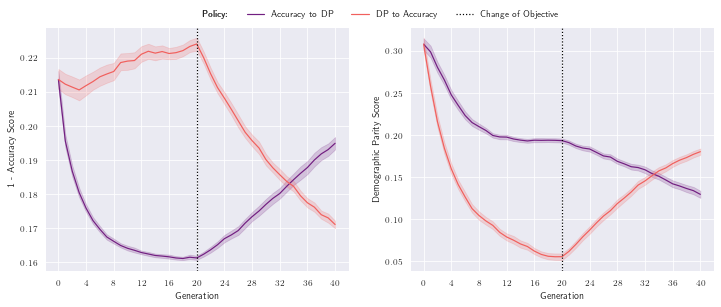

In [13]:
exp = 'lreps'
rdf = dfs[exp]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

sns.lineplot(ax=axes[0], x='gen', y='accu', data=rdf, hue=experiments[exp], palette=pal, legend=False)
g = sns.lineplot(ax=axes[1], x='gen', y='dp', data=rdf, hue=experiments[exp], palette=pal)
g.legend_.remove()

for ax in axes.flat:
    ax.axvline(x=20, label='Change of Objective', color='black', linestyle='dotted')
    
ylabs = ['1 - Accuracy Score', 'Demographic Parity Score']

for ax, yl in zip(axes.flat, ylabs):
    ax.set(xlabel='Generation', ylabel=yl)
    ax.set_xticks([4*i for i in range(11)])

th = [plt.plot([],marker='', ls='')[0]]
tl = [r'\textbf{Policy:}']

handles, labels = axes[1].get_legend_handles_labels()
handles = th + handles
labels = ['Accuracy to DP', 'DP to Accuracy', 'Change of Objective']
labels = tl + labels

l = fig.legend(handles,
               labels,
               ncol=7,
               loc='lower center', bbox_to_anchor=(0.5, 0.88), frameon=False)

plt.savefig(f"plots/{dset}_{exp}_mean.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# # ###############################
# # # Make rep_dict and pickle it #
# # ###############################

# import re

# rep_path = 'results/repeats'
# reps = os.listdir(rep_path)

# dsets = ['compas', 'german', 'income', 'titanic']

# opts = {
#     'acc_dp_reps': 'acc_dp_reps',
#     'all_metrics': 'opt_metric',
#     'dp_acc_reps': 'dp_acc_reps',
#     'dp_acc_ratios': 'dp_acc_ratio',
#     'lreps': 'reps',
# }

# rep_dict = {exp: {dset: {}
#                   for dset in dsets}
#             for exp in opts}


# for d in tqdm(dsets, desc='Dataset'):
#     ex_df = pd.read_csv(f"results/{d}_cv_exhaustive.csv")
#     best_df = pareto_front(ex_df)
#     for e in tqdm(opts, desc='Experiment', leave=False):
#         exp_list = list(filter(lambda k: (d in k) and (e in k), reps))
#         seeds = [re.sub("[^0-9]", "", e) for e in exp_list]
#         for f, s in tqdm(zip(exp_list, seeds), desc='Seed', leave=False, total=len(seeds)):
#             rep_dict[e][d][s] = {}
#             rep_dict[e][d][s]['df'] = pd.read_csv(f"{rep_path}/{f}")
#             rep_dict[e][d][s]['fronts'] = get_fronts(rep_dict[e][d][s]['df'], best_df, exp=opts[e])
#         rep_dict[e][d]['all_df'] = pd.concat([rep_dict[e][d][s]['df'] for s in seeds], ignore_index=True)

# # # Save rep_dict to pickle file
# # with open(f"{rep_path}/fronts.pickle", 'wb') as fp:
# #     pickle.dump(rep_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# # # Load fronts pickle
# # with open(f"{rep_path}/fronts.pickle", 'rb') as fp:
# #     rep_dict = pickle.load(fp)

# ######################
# # Remove stray seeds #
# ######################

# exp_names = ['acc_dp_reps', 'all_metrics', 'dp_acc_reps', 'dp_acc_ratios', 'lreps']
# dsets = ['compas', 'german', 'income', 'titanic']

# seed_sets = [set(rep_dict[name]['income'].keys()) for name in exp_names]
# common_seeds = seed_sets[0].intersection(*seed_sets[1:])

# for name in exp_names:
#     for dset in dsets:
#         rep_dict[name][dset] = {seed: rep_dict[name][dset][seed] for seed in common_seeds}

# ######################
# # Make the fronts df #
# ######################

# exp_names = ['acc_dp_reps', 'all_metrics', 'dp_acc_reps', 'dp_acc_ratios']
# dsets = ['compas', 'german', 'income', 'titanic']
# seeds = list(rep_dict['all_metrics']['income'].keys())
# seeds.remove('all_df')

# front_dfs = []
# for exp in exp_names:
#     for dset in dsets:
#         for seed in seeds:
#             opts = rep_dict[exp][dset][seed]['fronts'].keys()
#             for opt in opts:
#                 df = rep_dict[exp][dset][seed]['fronts'][opt]['fronts'][20]
#                 df['exp'] = exp
#                 df['dset'] = dset
#                 front_dfs.append(df)

# front_df = pd.concat(front_dfs, ignore_index=True)
# front_df.to_csv(f"{rep_path}/fronts_new.csv", index=False)

# ###################################
# # Make Avg Hausdorff distances df #
# ###################################

# seeds = list(rep_dict['all_metrics']['income'].keys())
# seeds.remove('all_df')

# opts = {
#     'acc_dp_reps': 'acc_dp_reps',
#     'all_metrics': 'opt_metric',
#     'dp_acc_reps': 'dp_acc_reps',
#     'dp_acc_ratios': 'dp_acc_ratio',
# }

# haus_dfs = []
# for exp in opts:
#     for dset in dsets:
#         for o in rep_dict[exp][dset][seeds[0]]['fronts'].keys():
#             for s in seeds:
#                 haus_dfs.append(pd.DataFrame({
#                     'dset': [dset] * 21,
#                     'seed': [s] * 21,
#                     'exp': [exp] * 21,
#                     'opt': [o] * 21,
#                     'gen': [i for i in range(21)],
#                     'haus': rep_dict[exp][dset][s]['fronts'][o]['haus'],
#                     'avg_haus': rep_dict[exp][dset][s]['fronts'][o]['avg_haus'],
#                     'dir_haus': rep_dict[exp][dset][s]['fronts'][o]['dir_haus'],
#                 }))
                
# haus_df = pd.concat(haus_dfs, ignore_index=True)
# haus_df.to_csv(f"{rep_path}/avg_haus_new.csv", index=False)

# ###########################
# # Make chromosome columns #
# ###########################

# front_df = pd.read_csv(f"{rep_path}/fronts_new.csv")

# front_df['splits'] = front_df['pipe'].str.split(',')
# tasks = {'sel': [], 'samp': [], 'scale': []}
# perms = []
# for i in range(front_df.shape[0]):
#     perm = []
#     for j in range(2,5):
#         spl = front_df.splits[i][j].rpartition('_')
#         k = spl[2]
#         v = spl[0]
#         tasks[k].append(v)
#         perm.append(k)
#     perm = tuple(perm)
#     perms.append(perm)
# front_df['enc'] = [front_df.splits[i][0].rpartition('_')[0]
#                 for i in range(front_df.shape[0])]
# front_df['imp'] = [front_df.splits[i][1].rpartition('_')[0]
#                 for i in range(front_df.shape[0])]
# for t in tasks:
#     front_df[t] = tasks[t]
# front_df['perm'] = perms
# front_df.drop(columns=['splits'], inplace=True)
# front_df.to_csv(f"{rep_path}/fronts_new.csv", index=False)

# #######################
# # Melt the exp values #
# #######################

# front_df.drop(columns=['exp'], inplace=True)
# front_cols = list(front_df.columns)
# to_melt = ['acc_dp_reps', 'opt_metric', 'dp_acc_reps', 'dp_acc_ratio']
# id_cols = [c for c in front_cols if c not in to_melt]
# melt_df = pd.melt(front_df, id_vars=id_cols, value_vars=to_melt, var_name='exp', value_name='exp_value')
# melt_df = melt_df[melt_df['exp_value'].notna()]
# melt_df.to_csv(f"{rep_path}/fronts_melt_new.csv", index=False)

In [4]:
##############################
# Estimated Paretos Analysis #
##############################

# Lists and variables for tables / plots
dsets = ['COMPAS', 'German', 'Income', 'Titanic']
# experiments = ['all_metrics', 'acc_dp_reps', 'dp_acc_reps', 'dp_acc_ratios']
experiments = ['dp_acc_ratio']
selected = ['(0, 10)', '(2, 8)', '(4, 6)', '(6, 4)', '(8, 2)', '(10, 0)']
rep_path = 'results/repeats'
tasks = ['enc', 'imp', 'sel', 'samp', 'scale', 'perm']
tasks = [t.upper() for t in tasks]

# Avg Haus distances DF
haus_df = pd.read_csv(f"{rep_path}/avg_haus_new.csv")
haus_df.columns = haus_df.columns.str.upper()
haus_df.DSET.replace({'compas': 'COMPAS', 'german': 'German', 'income': 'Income', 'titanic': 'Titanic'}, inplace=True)

# Fronts DF, remove eq. of opportunity and eq. odds experiments since analyses are on dp and accuracy
front_df = pd.read_csv(f"{rep_path}/fronts_melt_new.csv")
front_df.columns = front_df.columns.str.upper()
front_df.DSET.replace({'compas': 'COMPAS', 'german': 'German', 'income': 'Income', 'titanic': 'Titanic'}, inplace=True)
front_df = front_df[~front_df.EXP_VALUE.isin(['(0, 1, 0, 0)', '(0, 0, 1, 0)'])]
front_df = front_df[front_df.EXP.isin(experiments)]
front_df = front_df[front_df['EXP_VALUE'].isin(selected)]

tasks_renamed = ['ENCODER', 'IMPUTER', 'FEAT_SEL', 'SAMPLER', 'SCALER', 'PERM']
metric_cols = ['DP', 'EO', 'EQODDS', 'ACCU', 'PRECISION', 'RECALL', 'F1', 'ROC_AUC', 'DPR']

front_df.rename(columns={c:r for c, r in zip(tasks, tasks_renamed)}, inplace=True)
tasks = tasks_renamed

front_df.PERM = front_df.PERM.str.replace("'", "")

task_df = front_df.groupby(['PIPE', 'DSET']).first()[tasks]
mean_df = front_df.groupby(['PIPE', 'DSET']).first()[metric_cols]
occurs = front_df.groupby(['PIPE', 'DSET']).size()

grouped_df = pd.concat([task_df, mean_df], axis=1)
grouped_df['N_OCCURS'] = occurs
grouped_df = grouped_df.reset_index()

n_freq = 1
freq_grouped_df = grouped_df[grouped_df.N_OCCURS >= n_freq]
max_occurs = freq_grouped_df.N_OCCURS.max()

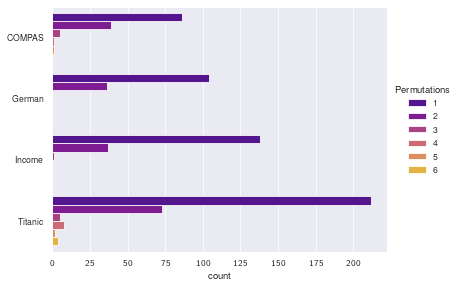

In [44]:
def perm(n, r):
    return math.factorial(n) / math.factorial(n - r)

task_no_perms = [t for t in tasks if t != 'PERM'] + ['DSET']

# Count 
count_df = freq_grouped_df.copy()
count_df['PERMS'] = 1
cdf = (count_df[task_no_perms + ['PERMS']]
       .groupby(task_no_perms)
       .count()
       .reset_index())

# Divide by the expected number of repetitions due to 'no' option
cdf['FIXED_PERMS'] = [math.ceil(row['PERMS']
                                / perm(3, (int(row['FEAT_SEL'] == 'no')
                                           + int(row.SAMPLER == 'no')
                                           + int(row.SCALER == 'no'))))
                      for i, row in cdf.iterrows()]

fig = sns.countplot(data=cdf, y='DSET', order=dsets, hue='FIXED_PERMS', palette=pal)
fig.set(ylabel=None)
fig.legend(title='Permutations', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# plt.savefig(f"plots/top_pipes_perms.pdf", bbox_inches='tight')
plt.show()

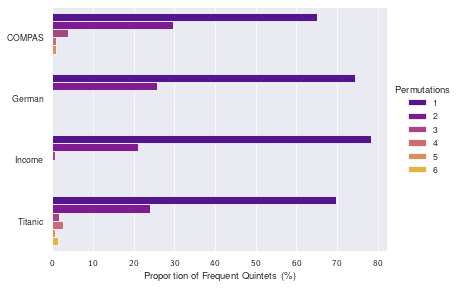

In [45]:
perms = sorted(cdf.FIXED_PERMS.unique())
perms_str = [str(i) for i in perms]
df = pd.DataFrame({
    str(i): cdf[cdf.FIXED_PERMS == i].groupby('DSET').ENCODER.count()
    for i in perms
})
df['DSET'] = dsets
df.fillna(0, inplace=True)


total = df[perms_str].sum(axis=1)

for i in perms_str:
    df.loc[:, i] = df.loc[:, i] * 100 / total

mdf = pd.melt(df, id_vars=['DSET'], value_vars=perms_str,
              var_name='Permutations', value_name='Percent')

fig = sns.barplot(data=mdf, y='DSET', x='Percent', order=dsets, hue='Permutations', palette=pal)
fig.set(ylabel=None,
        xlabel='Proportion of Frequent Quintets (\%)')
fig.legend(title='Permutations', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# plt.savefig(f"plots/top_pipes_perms_proportion.pdf", bbox_inches='tight')
plt.show()

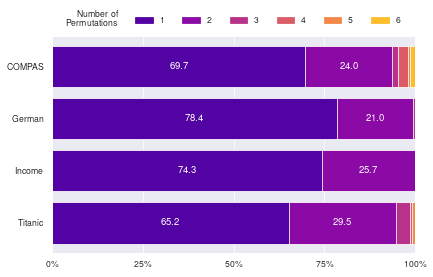

In [46]:
df2 = pd.DataFrame({
    str(i): df[perms_str[:i]].sum(axis=1) for i in perms
})
df2['DSET'] = list(reversed(dsets))
df2.fillna(0, inplace=True)

pally = sns.color_palette(pal, len(perms_str))
colors = {p: c for p, c in zip(perms_str, pally)}         

fig = plt.subplots(figsize=(6.5, 4))
rp = list(reversed(perms))
for i, p in enumerate(rp):
    width = df2[str(p)]
    plt.barh(y=df2['DSET'], width=width, color=pally[p-1])
    if i == 5:
        for i, v in enumerate(width):
            plt.text(v/2, i, f'{round(v, 1)}', color='white', fontweight='bold', ha='center', va='center')
    elif i == 4:
        p = rp[i + 1]
        w2 = df2[str(p)]
        for i, v in enumerate(width):
            plt.text((v + w2[i])/2, i, f'{round(v - w2[i], 1)}', color='white', fontweight='bold', ha='center', va='center')
# plt.xlabel('Proportion of Permutations per Pareto-Efficient Quintet (\%)')
plt.xlim(left=0, right=100)
ticks = np.linspace(0, 100, num=5)
plt.xticks(ticks, [f'{int(t)}\%' for t in ticks])

th = [plt.plot([],marker='', ls='')[0]]
tl = ['Number of\nPermutations']
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# labels = [int(i) for i in labels]
labels = tl + labels
handles = th + handles

# plt.xlabel('Proportion of Frequent Quintets')
# l = plt.legend(handles, labels,
#                title='Number of\nPermutations',
#                loc='center left', bbox_to_anchor=(1, 0.5),
#                frameon=False)
l = plt.legend(handles, labels,
#                title='Number of Permutations',
               ncol=len(perms) + 1,
               loc='lower center', bbox_to_anchor=(0.465, 1),
               frameon=False)
for t in l.texts:
    t.set_multialignment('right')
# plt.setp(l.get_title(), multialignment='center')
plt.savefig(f"plots/top_pipes_perms_stacked.pdf", bbox_inches='tight')
plt.show()

In [ ]:
######################
# Task Choice Counts #
######################

for task in tasks:
    fig = sns.countplot(x='DSET', order=dsets,
                        hue=task,
                        data=front_df, palette=pal)
    fig.legend(loc='center left',
               bbox_to_anchor=(1, 0.5),
               title=task,
               frameon=False)
    plt.show()

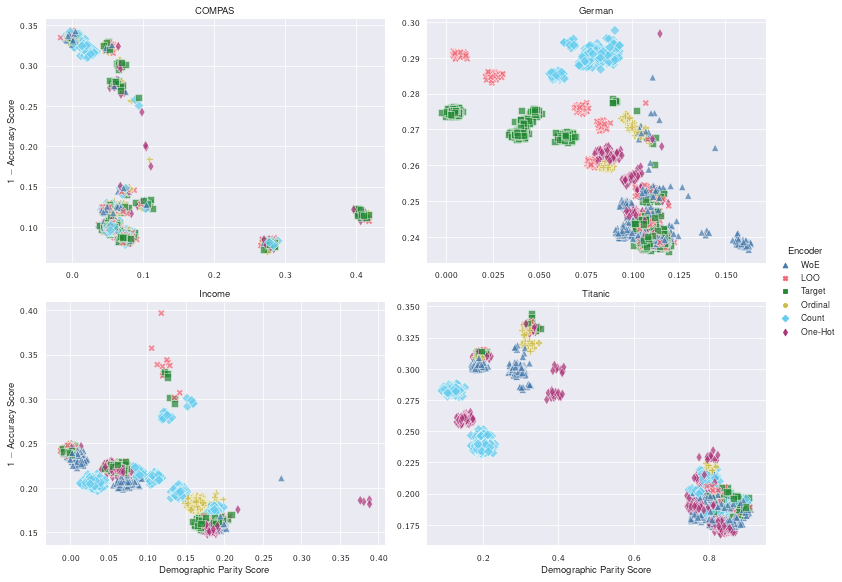

In [37]:
##############################
# DP / Accuracy Distribution #
##############################

markers = ('^', 'X', 's', 'P', 'D', 'd')
# tasks = ['ENCODER', 'IMPUTER', 'FEAT_SEL', 'SAMPLER', 'SCALER', 'PERM']
tasks = ['ENCODER']
dsets = ['COMPAS', 'German', 'Income', 'Titanic']

# sds = {'COMPAS': (0.003, 0.004), 'German': (0.0005, 0.0003), 'Income': (0.001, 0.001), 'Titanic': (0.003, 0.0004)}
sds = {'COMPAS': (0.0045, 0.003), 'German': (0.0018, 0.00065), 'Income': (0.004, 0.0028), 'Titanic': (0.01, 0.0017)}
dp_jits = {d: np.random.normal(0, sds[d][0], front_df[front_df.DSET == d].shape[0]) for d in dsets}
accu_jits = {d: np.random.normal(0, sds[d][1], front_df[front_df.DSET == d].shape[0]) for d in dsets}
freq_mod = front_df.copy()


for d in dsets:
    freq_mod.loc[freq_mod.DSET == d, 'ACCU'] = freq_mod[freq_mod.DSET == d].ACCU + accu_jits[d]
    freq_mod.loc[freq_mod.DSET == d, 'DP'] = freq_mod[freq_mod.DSET == d].DP + dp_jits[d]

freq_mod.ENCODER.replace({'count': 'Count', 'loo': 'LOO', 'onehot': 'One-Hot', 'ordinal': 'Ordinal', 'target': 'Target', 'woe': 'WoE'}, inplace=True)
for i, task in enumerate(tasks):
    g = sns.relplot(data=freq_mod, x='DP', y='ACCU',
                    col="DSET", col_order = dsets, col_wrap=2,
                    hue=task, style=task, s=50, markers=markers,
                    alpha=0.7, aspect=1.333, height=4, palette=bright_pal[:6],
                    facet_kws={'sharex': False, 'sharey': False})
    g.set_axis_labels("Demographic Parity Score", "1 − Accuracy Score")
    g._legend.remove()
    
    for j, ax in enumerate(g.axes.flat):
        ax.set_title(dsets[j])
        if j == 0:
            handles, labels = ax.get_legend_handles_labels()
            
    g.fig.legend(handles, labels,
                 title='Encoder',
                 loc='center right',
                 frameon=False)
    
    plt.savefig(f"plots/fair_accu_tradeoff_{task}.pdf", bbox_inches='tight')

In [ ]:
###################################
# Demographic Parity Distribution #
###################################

for task in tasks:
    g = sns.FacetGrid(front_df, hue=task, sharex=False, sharey=False,
                      col="DSET", col_order=dsets, aspect=1.333, palette=pal)
    g.map(sns.kdeplot, "DP")
    g.add_legend()

In [ ]:
#########################
# Accuracy Distribution #
#########################

for task in tasks:
    g = sns.FacetGrid(front_df, hue=task, sharex=False, sharey=False,
                      col="DSET", col_order=dsets, aspect=1.333, palette=pal)
    g.map(sns.kdeplot, "ACCU")
    g.add_legend()

In [ ]:
####################################
# Hausdorff Distances Distribution #
####################################

haus_dist = haus_df[haus_df.GEN == 20]
haus_ds = ['HAUS', 'AVG_HAUS', 'DIR_HAUS']

for h in haus_ds:
    g = sns.FacetGrid(haus_dist[haus_dist.EXP == 'dp_acc_reps'], col="DSET", hue='OPT',
                      sharex=False, sharey=False, aspect=1.333, palette=pal)
    g.map(sns.kdeplot, h)
    g.add_legend()

    # Adjust and add titles
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(exp)

In [37]:
import os
import random
from tqdm.notebook import tqdm

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
datasets = ['income', 'compas', 'german', 'titanic']
seed_everything(42)
seeds = [random.randint(1, 100000) for i in range(128)]

distances = {'avd': {}, 'haus': {}, 'dir': {}}

for dset in tqdm(datasets, desc='Dataset'):
    df = pd.read_csv(f"results/{dset}_cv_exhaustive.csv")
    pf = pareto_front(df)
    all_avds = []
    all_hds = []
    all_dhds = []
    for seed in tqdm(seeds, desc='Seed', leave=False):
        seed_everything(seed)
        sdf = df.sample(n=210, axis=0)
        avd_seed = []
        hd_seed = []
        dhd_seed = []
        for i in range(21):
            pdf = sdf.head(10*(i+1))
            ppf = pareto_front(pdf)
            avd = avg_haus(ppf, pf)
            hd = haus(ppf, pf)
            dhd = dir_haus(ppf, pf)
            avd_seed.append(avd)
            hd_seed.append(hd)
            dhd_seed.append(dhd)
        all_avds.append(avd_seed)
        all_hds.append(avd_seed)
        all_dhds.append(avd_seed)
    distances['avd'][dset] = all_avds
    distances['haus'][dset] = all_hds
    distances['dir'][dset] = all_dhds
    
metrics = ('avd', 'haus', 'dir')
avg_dists = {m:{d: np.mean(distances[m][d], axis=0) for d in datasets} for m in metrics}

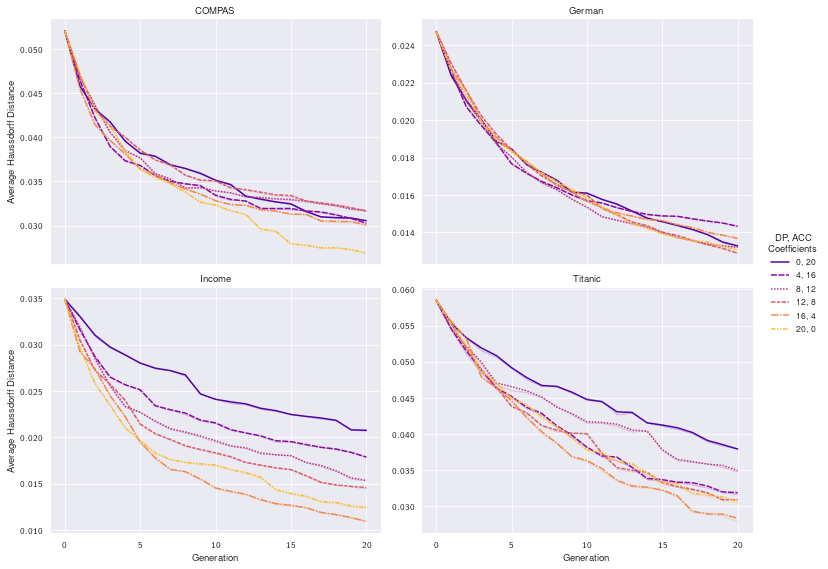

In [5]:
########################################
# Average Hausdorff Distance Evolution #
########################################

datasets = ['compas', 'german', 'income', 'titanic']
selected = ['(0, 10)', '(2, 8)', '(4, 6)', '(6, 4)', '(8, 2)', '(10, 0)']
h2 = haus_df.rename(columns={'AVG_HAUS': 'AVGHAUS'})
h2 = h2.rename(columns={'DIR_HAUS': 'DIRHAUS'})
h2 = h2[h2.OPT.isin(selected)]

d = {'ls': ['solid', (0, (4,1)), (0, (1,1)), (0, (3,1,2,1)), (0, (5,1,1,1)), (0, (3,1,1,1,1,1))]}
g = sns.FacetGrid(h2[h2.EXP == 'dp_acc_ratios'],
                  hue='OPT', hue_kws=d, col='DSET', col_wrap=2,
                  sharey=False, height=4, aspect=1.333, palette=pal)
g.map(sns.lineplot, 'GEN', 'AVGHAUS', ci=False, lw=1.5)

# axes = g.fig.axes
# x = [i for i in range(21)]
# for i, ax in enumerate(axes):
#     ax.plot(x, avg_dists['avd'][datasets[i]], color='black', label='Random')

g.set_axis_labels('Generation', 'Average Haussdorff Distance')
g.add_legend()
g._legend.remove()

handles, labels = g.axes.flat[0].get_legend_handles_labels()
labels = ('(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)')
labels = [l[1:-1] for l in labels]
l = g.fig.legend(handles,
                 labels,
                 title='DP, ACC\nCoefficients',
                 loc='center right',
                 bbox_to_anchor=(1.01, 0.5),
                 frameon=False)
# l.get_frame().set_color('white')
plt.setp(l.get_title(), multialignment='center')

for ax, dset in zip(g.axes.flat, dsets):
    ax.set_title(dset)
    ax.set_xticks([5*i for i in range(5)])
    
plt.savefig('plots/pareto_evo_avg.pdf', bbox_inches='tight')
plt.show()

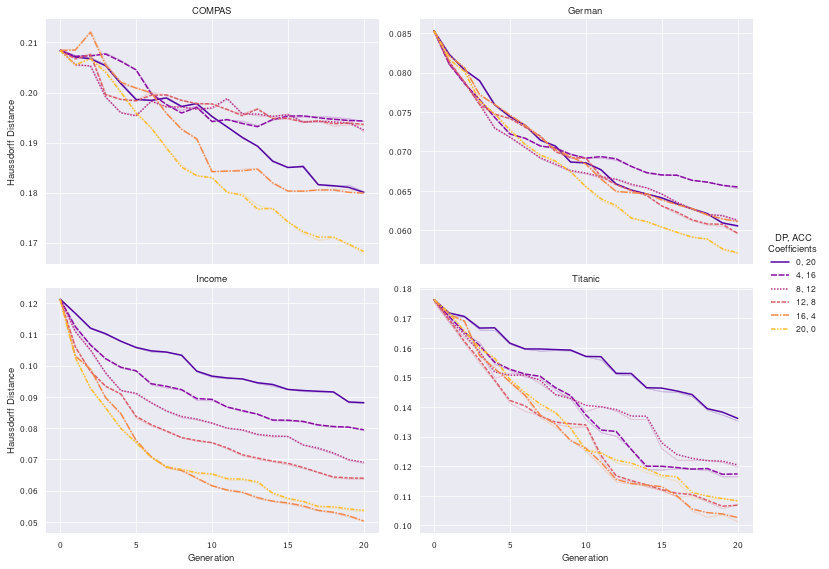

In [6]:
################################
# Hausdorff Distance Evolution #
################################

g = sns.FacetGrid(h2[h2.EXP == 'dp_acc_ratios'],
                  hue='OPT', hue_kws=d, col='DSET', col_wrap=2,
                  sharey=False, height=4, aspect=1.333, palette=pal)
g.map(sns.lineplot, 'GEN', 'HAUS', ci=False, lw=1.5)

# axes = g.fig.axes
# x = [i for i in range(21)]
# for i, ax in enumerate(axes):
#     ax.plot(x, avg_dists['haus'][datasets[i]], color='black', label='Random')

g.set_axis_labels('Generation', 'Haussdorff Distance')
g.add_legend()
g._legend.remove()

handles, labels = g.axes.flat[0].get_legend_handles_labels()
labels = ('(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)')
labels = [l[1:-1] for l in labels]
l = g.fig.legend(handles,
                 labels,
                 title='DP, ACC\nCoefficients',
                 loc='center right',
                 bbox_to_anchor=(1.01, 0.5),
                 frameon=False)
# l.get_frame().set_color('white')
plt.setp(l.get_title(), multialignment='center')

for ax, dset in zip(g.axes.flat, dsets):
    ax.set_title(dset)
    ax.set_xticks([5*i for i in range(5)])
    
plt.savefig('plots/pareto_evo_haus.pdf', bbox_inches='tight')
plt.show()

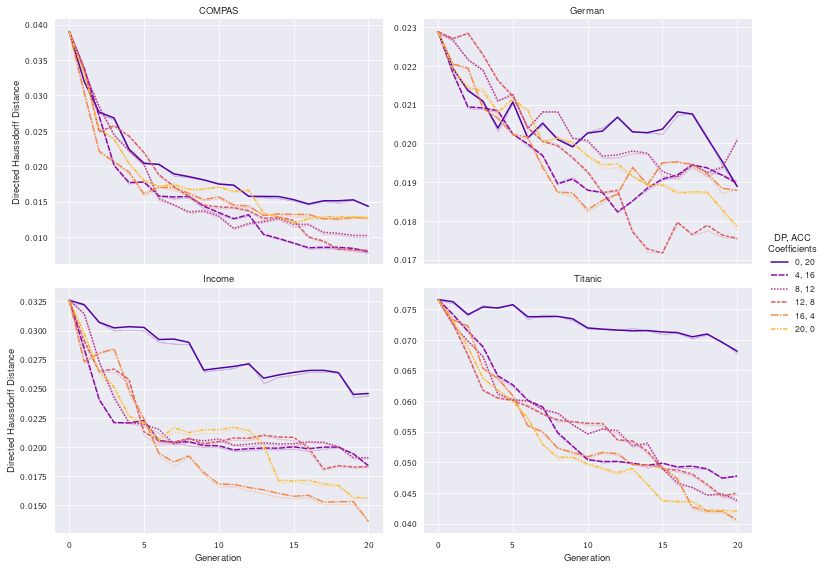

In [7]:
########################################
# Average Hausdorff Distance Evolution #
########################################

g = sns.FacetGrid(h2[h2.EXP == 'dp_acc_ratios'],
                  hue='OPT', hue_kws=d, col='DSET', col_wrap=2,
                  sharey=False, height=4, aspect=1.333, palette=pal)
g.map(sns.lineplot, 'GEN', 'DIRHAUS', ci=False, lw=1.5)

# axes = g.fig.axes
# x = [i for i in range(21)]
# for i, ax in enumerate(axes):
#     ax.plot(x, avg_dists['dir'][datasets[i]], color='black', label='Random')

g.set_axis_labels('Generation', 'Directed Haussdorff Distance')
g.add_legend()
g._legend.remove()

handles, labels = g.axes.flat[0].get_legend_handles_labels()
labels = ('(0, 20)', '(4, 16)', '(8, 12)', '(12, 8)', '(16, 4)', '(20, 0)')
labels = [l[1:-1] for l in labels]
l = g.fig.legend(handles,
                 labels,
                 title='DP, ACC\nCoefficients',
                 loc='center right',
                 bbox_to_anchor=(1.01, 0.5),
                 frameon=False)
# l.get_frame().set_color('white')
plt.setp(l.get_title(), multialignment='center')

for ax, dset in zip(g.axes.flat, dsets):
    ax.set_title(dset)
    ax.set_xticks([5*i for i in range(5)])
    
plt.savefig('plots/pareto_evo_dir.pdf', bbox_inches='tight')
plt.show()

In [58]:
####################################
# Decision Tree Regressor Analysis #
####################################

tasks = ['ENCODER', 'IMPUTER', 'FEAT_SEL', 'SAMPLER', 'SCALER', 'PERM']
all_imps = {}
all_trees = {}

for dset in front_df.DSET.unique():
    all_imps[dset] = {}
    all_trees[dset] = {}
    df = front_df[front_df.DSET == dset]
    task_df = df[tasks]
    metrics = {'ACCU': df.ACCU, 'DP': df.DP}

    for col in tasks:
        new_cols = pd.get_dummies(task_df[col], prefix=col)
        task_df = pd.concat([task_df, new_cols], axis=1)
        task_df.drop(columns=[col], inplace=True)
        
    for metric in metrics:
        reg = RandomForestRegressor(max_depth=10,
                                    random_state=42).fit(task_df,
                                                         metrics[metric])
        all_trees[dset][metric] = {}
        all_trees[dset][metric]['tree'] = reg
        all_trees[dset][metric]['df'] = task_df 
        imps = reg.feature_importances_
        importances = {col: importance for col,
                       importance in zip(task_df.columns, imps)}
        task_cols = {task: [col for col in importances if task in col]
                     for task in tasks}
        per_task_imps = {task: {col: importances[col]
                                for col in task_cols[task]}
                         for task in tasks}

        task_d = {}
        for task in tasks:
            for old_key in list(per_task_imps[task]):
                new_key = old_key.partition('_')[2]
                per_task_imps[task][new_key] = per_task_imps[task].pop(old_key)

            values = list(per_task_imps[task].values())
            keys = list(per_task_imps[task].keys())

            zipped_lists = zip(values, keys)
            sorted_pairs = sorted(zipped_lists, reverse=True)
            tuples = zip(*sorted_pairs)
            values, keys = [ list(tuple) for tuple in  tuples]
            task_d[task] = {'importances': values, 'tasks': keys}
        all_imps[dset][metric] = task_d

accu_df = pd.DataFrame({'DSET': [], 'TASK': [], 'TASK_OPT': [], 'ACCU_IMP': []})

for dset in all_imps:
    for task in all_imps[dset]['ACCU']:
        for imp, opt in zip(all_imps[dset]['ACCU'][task]['importances'],
                            all_imps[dset]['ACCU'][task]['tasks']):
            accu_df = accu_df.append({'DSET': dset,
                                      'TASK': task,
                                      'TASK_OPT': opt,
                                      'ACCU_IMP': imp}, ignore_index=True)
            
accu_df.sort_values(by=['DSET', 'TASK', 'TASK_OPT'], inplace=True)
accu_df.reset_index(inplace=True, drop=True)

dp_df = pd.DataFrame({'DSET': [], 'TASK': [], 'TASK_OPT': [], 'DP_IMP': []})

for dset in all_imps:
    for task in all_imps[dset]['DP']:
        for imp, opt in zip(all_imps[dset]['DP'][task]['importances'],
                            all_imps[dset]['DP'][task]['tasks']):
            dp_df = dp_df.append({'DSET': dset,
                                  'TASK': task,
                                  'TASK_OPT': opt,
                                  'DP_IMP': imp}, ignore_index=True)
            
dp_df.sort_values(by=['DSET', 'TASK', 'TASK_OPT'], inplace=True)
dp_df.reset_index(inplace=True, drop=True)

accu_df['DP_IMP'] = dp_df['DP_IMP']
accu_df['TT_OPT'] = accu_df.TASK + '_' + accu_df.TASK_OPT
accu_df.sort_values(by=['TT_OPT', 'DSET'], inplace=True)

accu_melt = pd.melt(accu_df,
                    id_vars=['DSET', 'TT_OPT'],
                    value_vars=['ACCU_IMP', 'DP_IMP'],
                    var_name='Metric',
                    value_name='Importance')

accu_melt.replace({'ACCU_IMP': 'Accuracy',
                   'DP_IMP': 'Demographic Parity',
                   'FEAT_SEL_SEL_no': 'F_SEL_no',
                   'FEAT_SEL_SEL_k_best': 'F_SEL_k_best'}, inplace=True)

In [59]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

pal2 = sns.color_palette(bright_pal, 2)
cm0 = sns.light_palette(pal2[0], as_cmap=True)
cm1 = sns.light_palette(pal2[1], as_cmap=True)

fdf = accu_melt.pivot(index=['TT_OPT'], columns=['Metric', 'DSET'], values='Importance').fillna(0).abs()
fdf.style.clear()
s = (
    fdf.style
    .format('{0:,.2f}')
    .background_gradient(cmap=cm0, subset=fdf.columns[0:4])
    .background_gradient(cmap=cm1, subset=fdf.columns[4:])
)
s.to_excel('styled.xlsx', engine='openpyxl')
s

In [ ]:
dset = 'Income'
metric = 'ACCU'

dot_data = export_graphviz(all_trees[dset][metric]['tree'],
                           feature_names=all_trees[dset][metric]['df'].columns,
                           proportion=True, filled=True, rounded=True, rotate=True,
                           out_file=None)  
graph = graphviz.Source(dot_data)  
graph

In [ ]:
##########################
# Linear Model Summaries #
##########################


task_df = front_df[tasks]
ACCU = front_df.ACCU
DP = front_df.DP

for col in tasks:
    new_cols = pd.get_dummies(task_df[col], prefix=col)
    task_df = pd.concat([task_df, new_cols], axis=1)
    task_df.drop(columns=[col], inplace=True)

to_drop = ['ENCODER_count', 'IMPUTER_mean', 'FEAT_SEL_no', 'SAMPLER_no', 'SCALER_no', "PERM_(sel, scale, samp)"]
task_df.drop(columns=to_drop, inplace=True)
task_const_df = sm.add_constant(task_df)

In [ ]:
est = sm.OLS(ACCU, task_const_df)
est2 = est.fit()
print(est2.summary())

In [ ]:
est = sm.OLS(DP, task_const_df)
est2 = est.fit()
print(est2.summary())

In [ ]:
n_bins = 10
front_df['cut_DP'] = pd.cut(front_df.DP, n_bins)
front_df['cut_ACCU'] = pd.cut(front_df.ACCU, n_bins)
cuts = ['cut_DP', 'cut_ACCU']
tab_df = front_df[cuts+tasks]

pd.crosstab(tab_df.cut_DP, tab_df.cut_ACCU).style.background_gradient(cmap=pal)

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=4, figsize=(32, 8))
cmap = sns.diverging_palette(250, 15, as_cmap=True)
# fig.subplots_adjust(top=0.94, hspace=0.1)
# fig.suptitle(f"{dset.capitalize()} - {exp} - Mean", fontsize=16)

for i, dset in enumerate(dsets):
    matrix = front_df[front_df.DSET == dset].drop(['SEED', 'GEN', 'DPR', 'PRECISION', 'RECALL'], axis=1).corr()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    matrix, mask = matrix.iloc[1:, :-1], mask[1:, :-1]
    sns.heatmap(matrix, mask=mask, ax=axes[i], 
                center=0, annot=True, cbar=False,
                fmt='.2f', square=True, cmap=pal)
    
    axes[i].set_yticklabels(matrix.index,
                            rotation=90,
                            va='center')
    axes[i].set_title(dset, fontsize=16)

In [ ]:
# Remove column limit
pd.set_option('display.max_columns', None)
# no need to use head anymore!
pd.set_option('display.max_rows', 10)
# To reset default
# pd.reset_option('display.max_columns')